<a href="https://colab.research.google.com/github/lollipop6370/ML2021/blob/main/GAN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Prepare

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
lr = 2e-4
batch_size = 128
image_size = 64  # MNIST 原始是 28x28，我們放大到 64x64
img_channels = 1 # MNIST 是灰階圖，所以 channel 是 1
z_dim = 100 # 隨機雜訊 z 的維度
num_epochs = 10

# Data Load

In [3]:
# --- Data Loading and Transformation ---
transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]
    ),
])

dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"成功載入資料集，共 {len(dataset)} 張圖片。")
print(f"使用的設備為: {device}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.83MB/s]

成功載入資料集，共 60000 張圖片。
使用的設備為: cuda


# Initial Model

In [9]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        # input : img_channels x 64 x 64
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1), # 64 x 32 x 32
            nn.LeakyReLU(0.2),
            self._block(64, 128, 4, 2, 1), # 128 x 16 x 16
            self._block(128, 256, 4, 2, 1), # 256 x 8 x 8
            self._block(256, 512, 4, 2, 1), # 512 x 4 x 4
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0), # 1x1x1
            nn.Sigmoid(),
        )

    def _block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.net(x)

# generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels):
        super(Generator, self).__init__()
        # input : z_dim x 1 x 1
        self.net = nn.Sequential(
            self._block(z_dim, 1024, 4, 1, 0), #  1024x4x4
            self._block(1024, 512, 4, 2, 1), #  512x8x8
            self._block(512, 256, 4, 2, 1), #  256x16x16
            self._block(256, 128, 4, 2, 1), #  128x32x32
            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1), #  1x64x64
            nn.Tanh(), # 輸出範圍 [-1, 1]
        )

    def _block(self, input_dim, output_dim, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(input_dim, output_dim, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

# initial
gen = Generator(z_dim, img_channels).to(device)
disc = Discriminator(img_channels).to(device)

In [11]:
# optimzer and loss function
# optimzer
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

# loss function
criterion = nn.BCELoss()

# 建立一個固定的雜訊，用於在訓練過程中觀察生成器的進化
fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)

# Train Loop

開始訓練...
Epoch [0/10] Batch 0/469 	Loss D: 0.7698, Loss G: 2.0826
Epoch [0/10] Batch 200/469 	Loss D: 0.0005, Loss G: 7.7837
Epoch [0/10] Batch 400/469 	Loss D: 0.0005, Loss G: 8.3697


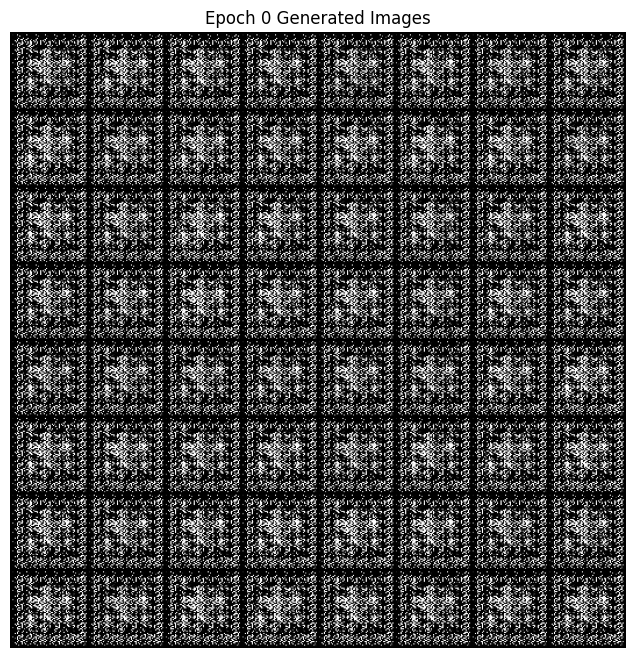

Epoch [1/10] Batch 0/469 	Loss D: 0.0178, Loss G: 6.7584
Epoch [1/10] Batch 200/469 	Loss D: 0.4169, Loss G: 1.8385
Epoch [1/10] Batch 400/469 	Loss D: 0.5811, Loss G: 2.1623


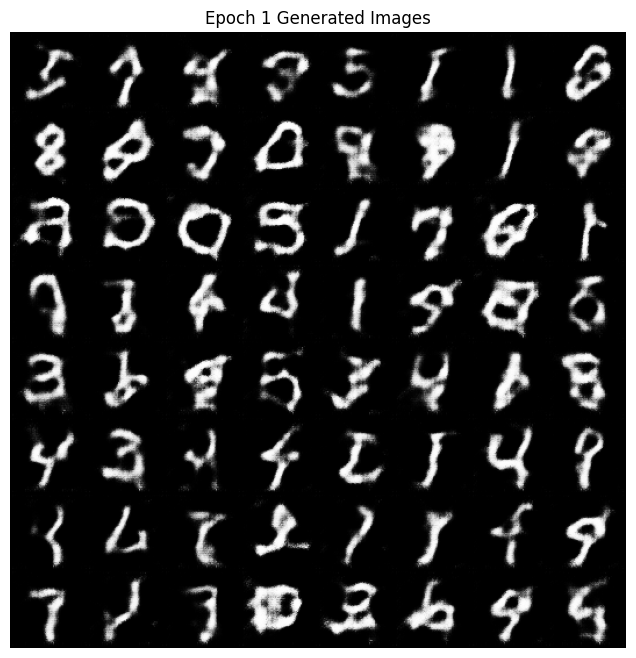

Epoch [2/10] Batch 0/469 	Loss D: 0.5740, Loss G: 1.1990
Epoch [2/10] Batch 200/469 	Loss D: 0.5237, Loss G: 1.1436
Epoch [2/10] Batch 400/469 	Loss D: 0.5975, Loss G: 0.9808


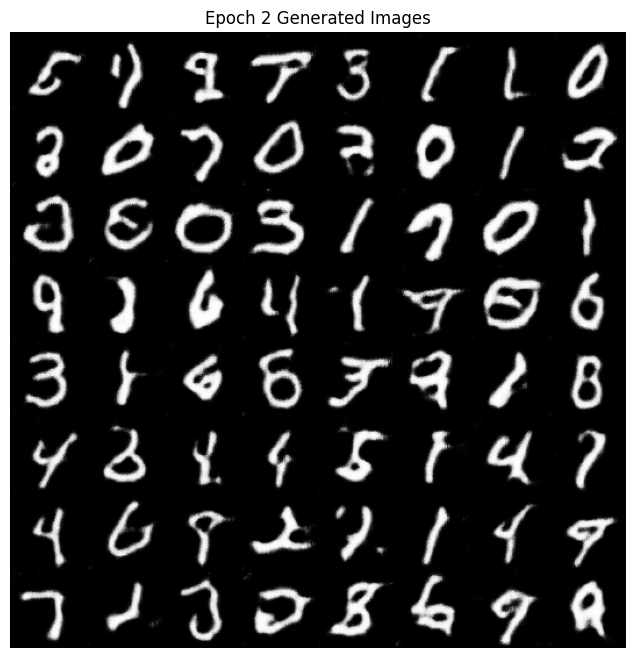

Epoch [3/10] Batch 0/469 	Loss D: 0.4620, Loss G: 2.0384
Epoch [3/10] Batch 200/469 	Loss D: 0.5102, Loss G: 1.0238
Epoch [3/10] Batch 400/469 	Loss D: 0.4783, Loss G: 1.3370


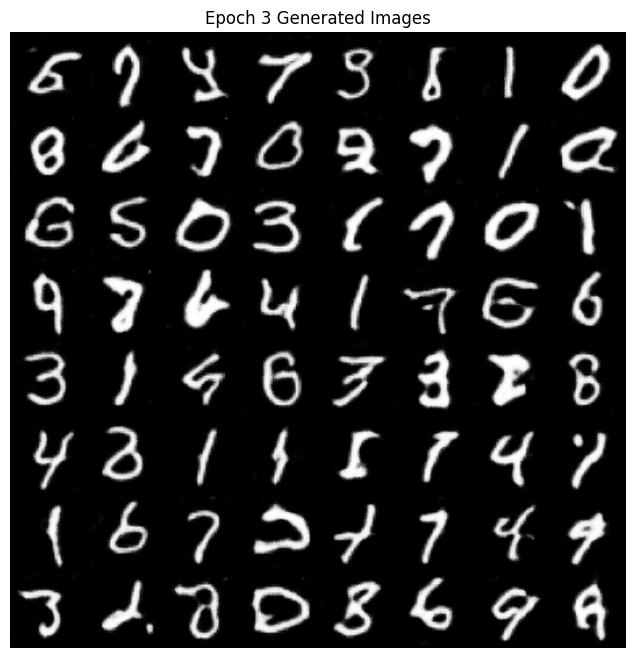

Epoch [4/10] Batch 0/469 	Loss D: 0.4480, Loss G: 2.1808
Epoch [4/10] Batch 200/469 	Loss D: 0.2894, Loss G: 2.5006
Epoch [4/10] Batch 400/469 	Loss D: 0.3207, Loss G: 1.9951


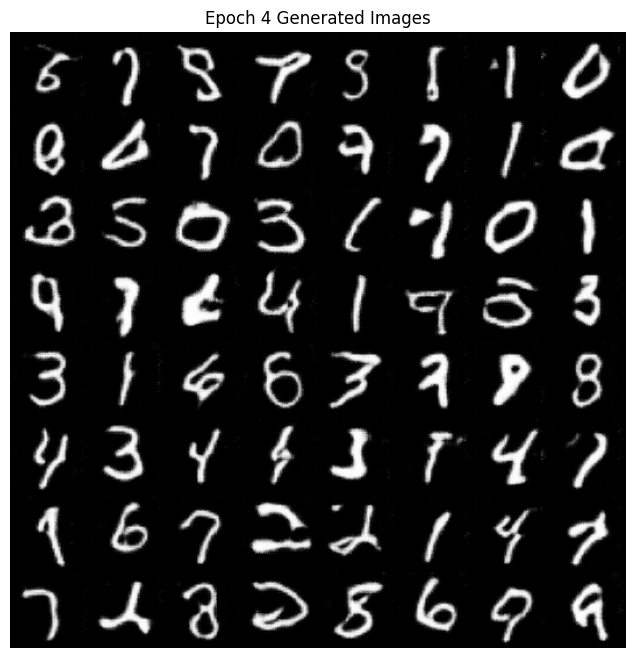

Epoch [5/10] Batch 0/469 	Loss D: 0.4802, Loss G: 1.0884
Epoch [5/10] Batch 200/469 	Loss D: 0.4400, Loss G: 4.1104
Epoch [5/10] Batch 400/469 	Loss D: 0.4704, Loss G: 3.3903


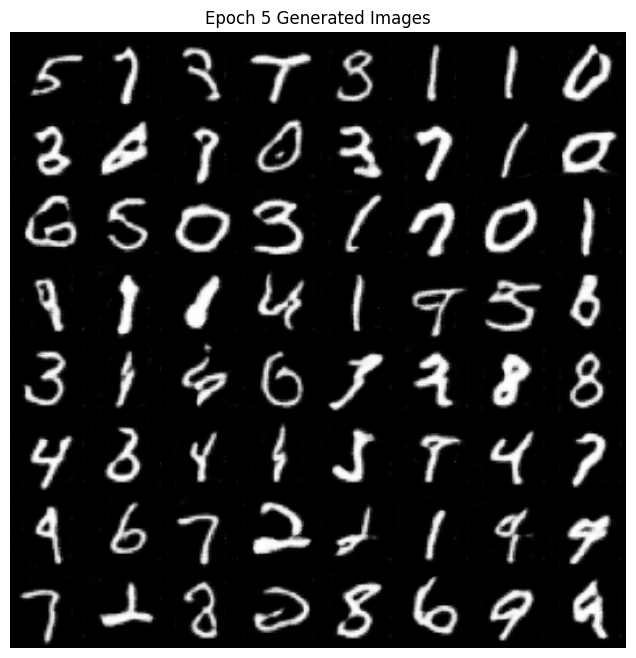

Epoch [6/10] Batch 0/469 	Loss D: 0.2550, Loss G: 2.7906
Epoch [6/10] Batch 200/469 	Loss D: 0.0416, Loss G: 3.5227
Epoch [6/10] Batch 400/469 	Loss D: 0.2081, Loss G: 2.6319


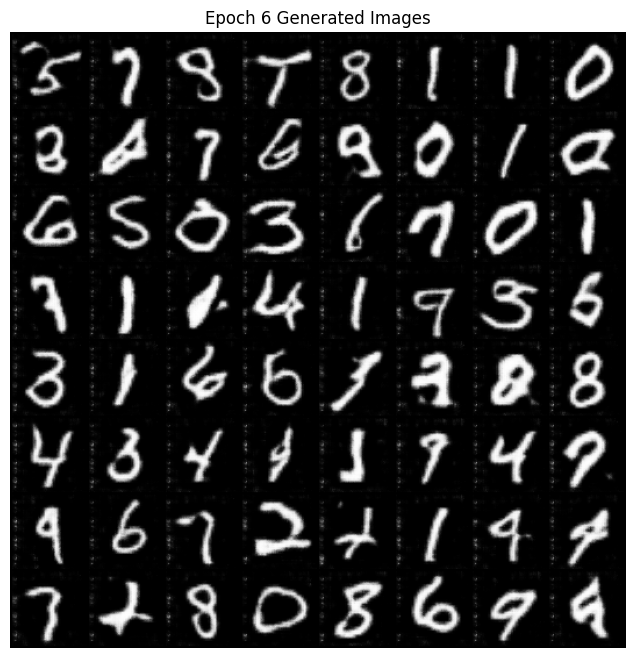

Epoch [7/10] Batch 0/469 	Loss D: 0.0317, Loss G: 4.5189
Epoch [7/10] Batch 200/469 	Loss D: 0.0408, Loss G: 3.6364
Epoch [7/10] Batch 400/469 	Loss D: 0.2360, Loss G: 3.0431


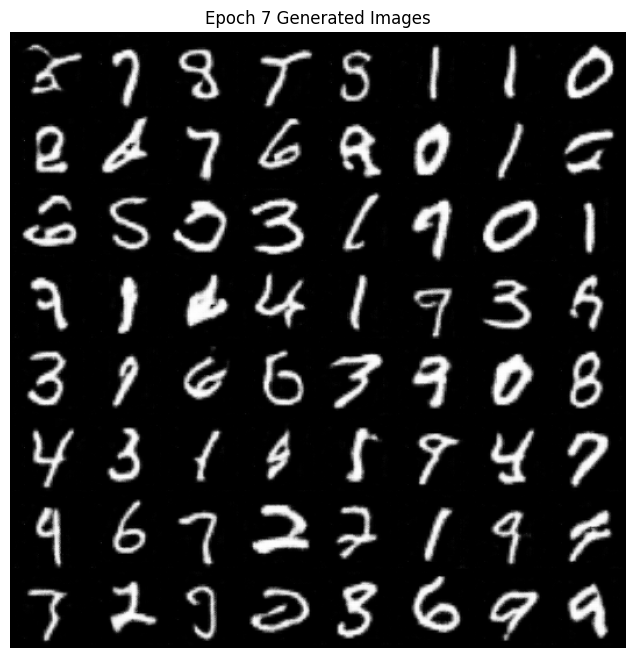

Epoch [8/10] Batch 0/469 	Loss D: 0.4155, Loss G: 4.5912
Epoch [8/10] Batch 200/469 	Loss D: 0.0180, Loss G: 4.4158
Epoch [8/10] Batch 400/469 	Loss D: 0.0803, Loss G: 4.0155


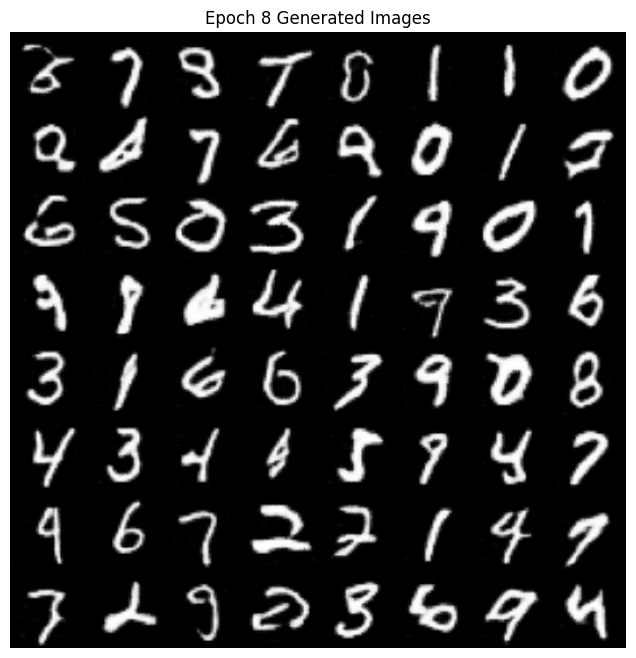

Epoch [9/10] Batch 0/469 	Loss D: 0.2796, Loss G: 4.1073
Epoch [9/10] Batch 200/469 	Loss D: 0.2064, Loss G: 1.3204
Epoch [9/10] Batch 400/469 	Loss D: 0.0522, Loss G: 2.7781


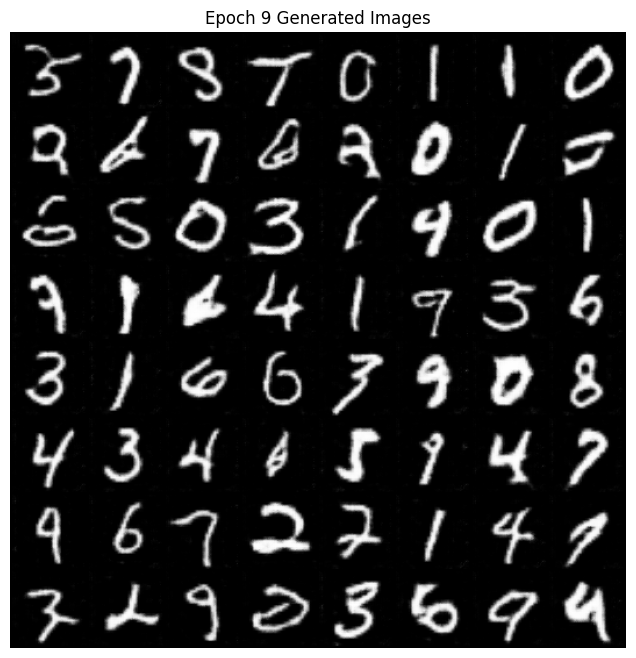

訓練完成！


In [12]:
gen.train()
disc.train()

print("開始訓練...")

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)

        ### 訓練判別器 (Discriminator)
        # 目標: max log(D(x)) + log(1 - D(G(z)))

        # 1. 使用真實圖片訓練
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real)) # 標籤為 1

        # 2. 使用偽造圖片訓練
        disc_fake = disc(fake.detach()).reshape(-1) # .detach() 避免梯度傳到生成器
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake)) # 標籤為 0

        # 合併損失並更新
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### 訓練生成器 (Generator)
        # 目標: min log(1 - D(G(z))) -> 等價於 max log(D(G(z)))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output)) # 我們希望判別器把假的判成真的 (標籤為 1)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # 顯示訓練進度
        if batch_idx % 200 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \t"
                f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
            )

    # 每個 epoch 結束後，用固定的雜訊生成一批圖片來觀察進展
    with torch.no_grad():
        fake_samples = gen(fixed_noise)
        img_grid = make_grid(fake_samples, normalize=True)

        plt.figure(figsize=(8,8))
        plt.imshow(np.transpose(img_grid.cpu().numpy(), (1, 2, 0)))
        plt.title(f"Epoch {epoch} Generated Images")
        plt.axis("off")
        plt.show()

print("訓練完成！")

# Generate Results